In [426]:
import json
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn import linear_model, metrics
from scipy import optimize
import scipy
import numpy as np
import random
import gzip
import math
import string

In [427]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield eval(l)

null = None
# count = 0

dataset = []
for l in parse("renttherunway_final_data.json.gz"):
  if l["rating"] != null:
    dataset.append(l)
    # count += 1
    # if count >= 100000:
    #   break


In [428]:
# Train/Test split
dataTrain = dataset[:80000]
dataValid = dataset[80000:100000]
dataTest = dataset[100000:120000]


print(len(dataTrain))
print(len(dataValid))
print(len(dataTest))
print(dataset[10])

80000
20000
20000
{'fit': 'small', 'user_id': '185966', 'bust size': '34b', 'item_id': '1077123', 'weight': '135lbs', 'rating': '8', 'rented for': 'party', 'review_text': "The dress arrived with a small hole in the beading on the front but wasn't too noticeable. Glad I was able to get two sizes because the 4 was a little tight and would've made for an uncomfortable night of dancing! ", 'body type': 'athletic', 'review_summary': "It was fun to wear a dress I wouldn't normally buy! ", 'category': 'dress', 'height': '5\' 3"', 'size': 12, 'age': '33', 'review_date': 'January 2, 2018'}


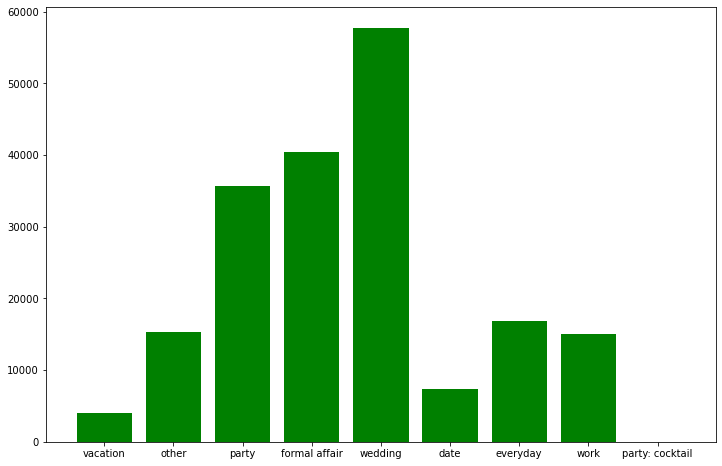

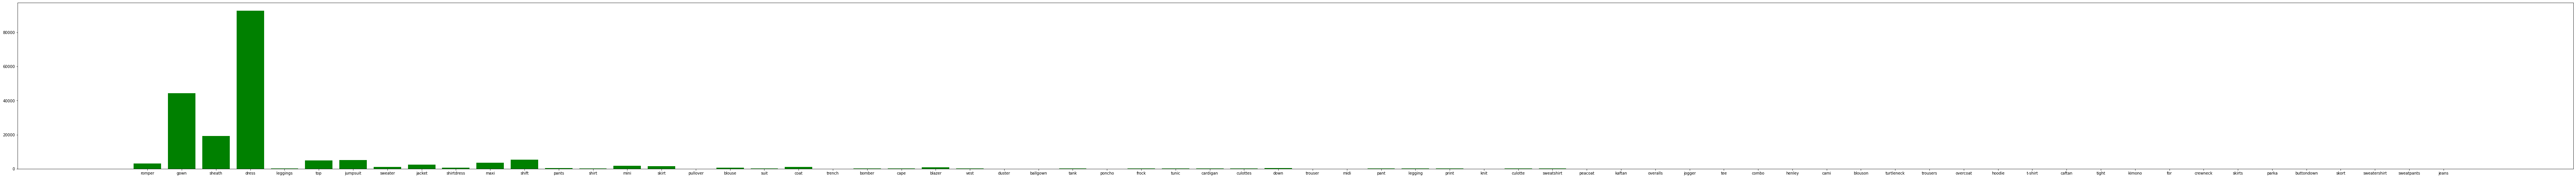

In [429]:
# Might be useful plots:
reviewCountPerReason = defaultdict(int)
reviewCountPerCategory = defaultdict(int)
for review in dataset:
    if 'rented for' in review.keys():
        reviewCountPerReason[review["rented for"]] += 1
    if 'category' in review.keys():
        reviewCountPerCategory[review["category"]] += 1

plt.figure(figsize=(12, 8))
width = 0.8
plt.bar(reviewCountPerReason.keys(), reviewCountPerReason.values(), width, color='g')
plt.show()

plt.figure(figsize=(120, 8))
width = 0.8
plt.bar(reviewCountPerCategory.keys(), reviewCountPerCategory.values(), width, color='g')
plt.show()

In [430]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

Ytrain = [float(y['rating']) for y in dataTrain]
Yvalid = [float(y['rating']) for y in dataValid]
Ytest = [float(y['rating']) for y in dataTest]

## 1. Estimates a rating from the number of times the exclamation mark (!) symbol is used in the review

In [431]:
def feature1(data):
    return [1, float(data['review_text'].count('!'))]

Xtrain = [feature1(x) for x in dataTrain]
Xtest = [feature1(x) for x in dataTest]

theta, residuals, rank, s = np.linalg.lstsq(Xtrain,Ytrain,rcond=None)

predictions = np.dot(Xtest, theta)
print("MSE: " + str(MSE(predictions, Ytest)))

MSE: 2.0250759593502092


## 2. Estimates a rating from the number of times the exclamation mark (!) symbol is used in the review and the review summary

In [432]:
def feature2(data):
    return [1, float(data['review_text'].count('!')), float(data['review_summary'].count('!'))]

Xtrain = [feature2(x) for x in dataTrain]
Xtest = [feature2(x) for x in dataTest]

theta, residuals, rank, s = np.linalg.lstsq(Xtrain,Ytrain,rcond=None)

predictions = np.dot(Xtest, theta)
print("MSE: " + str(MSE(predictions, Ytest)))

MSE: 1.9828574930616412


## 3. Estimates a rating from the length of the review and the number of times the exclamation mark (!) symbol is used in the review and the review summary

In [433]:
def feature3(data):
    return [1, float(len(data['review_text'])), float(data['review_text'].count('!')), float(data['review_summary'].count('!'))]

Xtrain = [feature3(x) for x in dataTrain]
Xtest = [feature3(x) for x in dataTest]

theta, residuals, rank, s = np.linalg.lstsq(Xtrain,Ytrain,rcond=None)

predictions = np.dot(Xtest, theta)
print("MSE: " + str(MSE(predictions, Ytest)))

MSE: 1.9690842816601497


## 4. Train a model that fits a polynomial function to estimate ratings based on our ‘!’ feature

In [434]:
def feature4(datum, deg):
    # feature for a specific polynomial degree
    val = float(datum['review_text'].count('!'))
    res = [1, val]
    i = 1
    while i < deg:
        res.append(val ** (i+1))
        i += 1
    return res

mses = []
for deg in range(2,10):
    Xtrain = [feature4(x, deg) for x in dataTrain]
    Xtest = [feature4(x, deg) for x in dataTest]

    theta, residuals, rank, s = np.linalg.lstsq(Xtrain,Ytrain,rcond=None)
    predictions = np.dot(Xtest, theta)
    print("MSE for count('!') with degree " + str(deg) + " :" + str(MSE(predictions, Ytest)))

MSE for count('!') with degree 2 :2.015078947792513
MSE for count('!') with degree 3 :2.006814004949877
MSE for count('!') with degree 4 :2.0031166090989916
MSE for count('!') with degree 5 :2.000153505768482
MSE for count('!') with degree 6 :1.999283148583284
MSE for count('!') with degree 7 :1.9992357320352665
MSE for count('!') with degree 8 :78.67828066138725
MSE for count('!') with degree 9 :83.43656359939712


## 5. Use reason / category average to predict (baseline)

In [435]:
train_averagePerReason = defaultdict(float)
train_reviewCountPerReason = defaultdict(int)

train_averagePerCategory = defaultdict(list)
for review in dataTrain:
    if 'rented for' in review.keys():
        train_reviewCountPerReason[review["rented for"]] += 1
        train_averagePerReason[review["rented for"]] += float(review["rating"])
    if 'category' in review.keys():
        train_averagePerCategory[review['category']].append(float(review['rating']))
        
for cat in train_averagePerCategory:
    train_averagePerCategory[cat] = sum(train_averagePerCategory[cat]) / len(train_averagePerCategory[cat])

predictions = []
labels = []
for review in dataTest:
    if 'rented for' in review.keys():
        if review['rented for'] in train_averagePerReason.keys():
            predictions.append(train_averagePerReason[review["rented for"]] / train_reviewCountPerReason[review["rented for"]])
            labels.append(float(review["rating"]))
print("(Use Reason) MSE: " + str(MSE(predictions, labels)))


predictions = []
labels = []
for review in dataTest:
    if 'category' in review.keys():
        if review['category'] in train_averagePerCategory.keys():
            predictions.append(train_averagePerCategory[review['category']])
            labels.append(float(review["rating"]))
print("(Use category) MSE: " + str(MSE(predictions, labels)))

(Use Reason) MSE: 2.0769693290318956
(Use category) MSE: 2.08581394236695


## 6. Item User Pair Model using Jaccard Similarity

In [436]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

itemAverages = defaultdict(list)
reviewsPerUser = defaultdict(list)
usersPerItem = defaultdict(set)
ratingMean = []

for d in dataTrain:
    u,i = d['user_id'], d['item_id']
    itemAverages[i].append(float(d['rating']))
    reviewsPerUser[u].append(d)
    usersPerItem[i].add(u)
    ratingMean.append(float(d['rating']))

for i in itemAverages:
    itemAverages[i] = sum(itemAverages[i]) / len(itemAverages[i])

ratingMean = sum(ratingMean) / len(ratingMean)
    
def predictRating(user,item, reason):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['item_id']
        if i2 == item: continue
        ratings.append(float(d['rating']) - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        if item in itemAverages:
            return itemAverages[item]
        # elif reason and reason in train_averagePerReason.keys():
        #     return train_averagePerReason[reason] / train_reviewCountPerReason[reason]
        else:
            return ratingMean
        
predictions = []
labels = []
for d in dataTest:
    u,i,r = d['user_id'], d['item_id'], float(d['rating'])
    if 'rented for' in d.keys():
        reason = d['rented for']
    else:
        reason = None
    predictions.append(predictRating(u, i, reason))
    labels.append(r)

print("MSE: " + str(MSE(predictions, labels)))

MSE: 2.1852615045597736


## 7. Latent Factor model

In [437]:
# latent factor-based recommender
# f(u, i) = alpha + beta_u + beta_i

ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
for d in dataTrain:
    u,i, r = d['user_id'], d['item_id'], float(d['rating'])
    ratingsPerUser[u].append((i,r))
    ratingsPerItem[i].append((u,r))
    usersPerItem[i].add(u)
    itemsPerUser[u].add(i)

# Preparation
nUsers = len(ratingsPerUser)
nItems = len(ratingsPerItem)
users = list(ratingsPerUser.keys())
items = list(ratingsPerItem.keys())

alpha = ratingMean
userBiases = defaultdict(float)
itemBiases = defaultdict(float)

ratingsTrain = [(d['user_id'],d['item_id'],float(d['rating'])) for d in dataTrain]
ratingsTest = [(d['user_id'],d['item_id'],float(d['rating'])) for d in dataTest]
N = len(ratingsTrain)
labels = [r for _, _, r in ratingsTrain]
labelsTest = [r for _, _, r in ratingsTest]

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item]

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))
    
# cost function (MSE + Regularization term)
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(u, b) for u, b, _ in ratingsTrain]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for b in itemBiases:
        cost += lamb*itemBiases[b]**2
    return cost

# derivative function
def derivative(theta, labels, lamb):
    unpack(theta)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    
    for u, b, r in ratingsTrain:
        pred = prediction(u, b)
        diff = pred - r
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[b] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for b in itemBiases:
        dItemBiases[b] += 2*lamb*itemBiases[b]
    
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[b] for b in items]
    return np.array(dtheta)

# perform gradient decent
result = scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                             derivative, args = (labels, 0.01))

def rate_predict(u, b):
    if u in userBiases and b in itemBiases:
        return prediction(u,b)
    elif u in userBiases:
        return alpha + userBiases[u]
    elif b in itemBiases:
        return alpha + itemBiases[b]
    else:
        return alpha
    
unpack(result[0])
predictions = [rate_predict(u, b) for u, b, _ in ratingsTest]
print("Test MSE:" + str(MSE(predictions, labelsTest)))

MSE = 2.0376181093762638
MSE = 2.014620878051403
MSE = 2.0478599172173433
MSE = 2.014501702588433
MSE = 2.0142835631529334
MSE = 2.013414690425561
MSE = 2.012209948180488
MSE = 2.012080546478788
MSE = 2.012071659928252
MSE = 2.0120632772327625
Test MSE:2.080772104786376


## 8. Bag of words model (on review text) with Unigram only

In [438]:
# Unigram
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in dataTrain:
  r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
  for w in r.split():
    wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:1000]]

wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Xtrain = [feature(d) for d in dataTrain]
ytrain = [float(d['rating']) for d in dataTrain]

Xtest = [feature(d) for d in dataTest]
ytest = [float(d['rating']) for d in dataTest]

clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(Xtrain, ytrain)
theta = clf.coef_
predictions = clf.predict(Xtest)
unigram_MSE = MSE(predictions, ytest)
mostCommonUnigrams = (unigram_MSE, words[:])
print("MSE: " + str(unigram_MSE))

MSE: 1.5266081248368133


## 9. Bag of words model with Bigram only

In [439]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in dataTrain:
  r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
  ws = r.split()
  ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
  for w in ws2:
    wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:1000]]

wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    for w in ws2:
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Xtrain = [feature(d) for d in dataTrain]
ytrain = [float(d['rating']) for d in dataTrain]

Xtest = [feature(d) for d in dataTest]
ytest = [float(d['rating']) for d in dataTest]

clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(Xtrain, ytrain)
theta = clf.coef_
predictions = clf.predict(Xtest)
bigram_MSE = MSE(predictions, ytest)
mostCommonBigrams = (bigram_MSE, words[:])
print("MSE: " + str(bigram_MSE))

MSE: 1.5950698200953413


# 10. Bag of words model with Unigram, Bigram Combination

In [440]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in dataTrain:
  r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
  ws = r.split()
  ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
  for w in ws + ws2:
    wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:1000]]

wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    for w in ws + ws2:
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Xtrain = [feature(d) for d in dataTrain]
ytrain = [float(d['rating']) for d in dataTrain]

Xtest = [feature(d) for d in dataTest]
ytest = [float(d['rating']) for d in dataTest]

clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(Xtrain, ytrain)
theta = clf.coef_
predictions = clf.predict(Xtest)
common_MSE = MSE(predictions, ytest)
mostCommonBoth = (common_MSE, words[:])
print("MSE: " + str(common_MSE))

MSE: 1.5227845680378003


## 11. Bag of words model (on review text + category + rented for + review summary) with Unigram only

In [441]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in dataTrain:
  r_text = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
  r_summary = ''.join([c for c in d['review_summary'].lower() if not c in punctuation])
  r_reason = d['rented for'] if 'rented for' in d.keys() else ""
  r_cat = d['category'] if 'category' in d.keys() else ""
  r = r_text + r_summary + r_reason + r_cat
  for w in r.split():
    wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:1000]]

wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

def feature(datum):
    feat = [0]*len(words)
    r_text = ''.join([c for c in datum['review_text'].lower() if not c in punctuation])
    r_summary = ''.join([c for c in d['review_summary'].lower() if not c in punctuation])
    r_reason = d['rented for'] if 'rented for' in d.keys() else ""
    r_cat = d['category'] if 'category' in d.keys() else ""
    r = r_text + r_summary + r_reason + r_cat
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Xtrain = [feature(d) for d in dataTrain]
ytrain = [float(d['rating']) for d in dataTrain]

Xtest = [feature(d) for d in dataTest]
ytest = [float(d['rating']) for d in dataTest]

clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(Xtrain, ytrain)
theta = clf.coef_
predictions = clf.predict(Xtest)
unigram_MSE = MSE(predictions, ytest)
mostCommonUnigrams = (unigram_MSE, words[:])
print("MSE: " + str(unigram_MSE))

MSE: 1.5444732221891957


## 12. Bag of words model with N-gram Combination

### 1,2,3-GRAM

In [ ]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in dataTrain:
  r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
  ws = r.split()
  ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
  ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
  for w in ws + ws2 + ws3:
    wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:1000]]

wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

def feature(datum, n):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
    for w in ws + ws2 + ws3:
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Xtrain = [feature(d) for d in dataTrain]
ytrain = [float(d['rating']) for d in dataTrain]

Xtest = [feature(d) for d in dataTest]
ytest = [float(d['rating']) for d in dataTest]

clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(Xtrain, ytrain)
theta = clf.coef_
predictions = clf.predict(Xtest)
one_three_gram_MSE = MSE(predictions, ytest)
print("1_3-gram MSE: " + str(one_three_gram_MSE))

### 1,2,3,4-GRAM

In [ ]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in dataTrain:
  r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
  ws = r.split()
  ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
  ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
  ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
  for w in ws + ws2 + ws3 + ws4:
    wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:1000]]

wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

def feature(datum, n):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
    ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
    for w in ws + ws2 + ws3 + ws4:
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Xtrain = [feature(d) for d in dataTrain]
ytrain = [float(d['rating']) for d in dataTrain]

Xtest = [feature(d) for d in dataTest]
ytest = [float(d['rating']) for d in dataTest]

clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(Xtrain, ytrain)
theta = clf.coef_
predictions = clf.predict(Xtest)
one_four_gram_MSE = MSE(predictions, ytest)
print("1_4-gram MSE: " + str(one_four_gram_MSE))

### 1,2,3,4,5-GRAM

In [ ]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in dataTrain:
  r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
  ws = r.split()
  ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
  ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
  ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
  ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
  for w in ws + ws2 + ws3 + ws4 + ws5:
    wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:1000]]

wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

def feature(datum, n):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
    ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
    ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
    for w in ws + ws2 + ws3 + ws4 + ws5:
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Xtrain = [feature(d) for d in dataTrain]
ytrain = [float(d['rating']) for d in dataTrain]

Xtest = [feature(d) for d in dataTest]
ytest = [float(d['rating']) for d in dataTest]

clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(Xtrain, ytrain)
theta = clf.coef_
predictions = clf.predict(Xtest)
one_five_gram_MSE = MSE(predictions, ytest)
print("1_5-gram MSE: " + str(one_five_gram_MSE))

## 12. Combonation of regression + user-item-latent factor + bag of words


In [442]:
# predict = a1 * regression_pred + a2 * user-item_pred + a3 * bag_of_word_pred

a1 = np.linspace(0,1,100)
a2 = np.linspace(0,1,100)
para_lst = []
for cur_a1 in a1:
    for cur_a2 in a2:
        a3 = 1.0 - cur_a1 - cur_a2
        if a3 >= 0:
            para_lst.append((cur_a1, cur_a2, a3))

In [443]:
def feature3(data):
    return [1, float(len(data['review_text'])), float(data['review_text'].count('!')), float(data['review_summary'].count('!'))]

Xtrain = [feature3(x) for x in dataTrain]
XValid = [feature3(x) for x in dataValid]
Xtest = [feature3(x) for x in dataTest]

theta, residuals, rank, s = np.linalg.lstsq(Xtrain,Ytrain,rcond=None)

predictions_regression_valid = np.dot(XValid, theta)
predictions_regression_test = np.dot(Xtest, theta)

In [444]:
# latent factor-based recommender
# f(u, i) = alpha + beta_u + beta_i

ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)
for d in dataTrain:
    u,i, r = d['user_id'], d['item_id'], float(d['rating'])
    ratingsPerUser[u].append((i,r))
    ratingsPerItem[i].append((u,r))
    usersPerItem[i].add(u)
    itemsPerUser[u].add(i)

# Preparation
nUsers = len(ratingsPerUser)
nItems = len(ratingsPerItem)
users = list(ratingsPerUser.keys())
items = list(ratingsPerItem.keys())

alpha = ratingMean
userBiases = defaultdict(float)
itemBiases = defaultdict(float)

ratingsTrain = [(d['user_id'],d['item_id'],float(d['rating'])) for d in dataTrain]
ratingsValid = [(d['user_id'],d['item_id'],float(d['rating'])) for d in dataValid]
ratingsTest = [(d['user_id'],d['item_id'],float(d['rating'])) for d in dataTest]
N = len(ratingsTrain)
labels = [r for _, _, r in ratingsTrain]
labelsValid = [r for _, _, r in ratingsValid]
labelsTest = [r for _, _, r in ratingsTest]

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item]

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))
    
# cost function (MSE + Regularization term)
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(u, b) for u, b, _ in ratingsTrain]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for b in itemBiases:
        cost += lamb*itemBiases[b]**2
    return cost

# derivative function
def derivative(theta, labels, lamb):
    unpack(theta)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    
    for u, b, r in ratingsTrain:
        pred = prediction(u, b)
        diff = pred - r
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[b] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for b in itemBiases:
        dItemBiases[b] += 2*lamb*itemBiases[b]
    
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[b] for b in items]
    return np.array(dtheta)

# perform gradient decent
result = scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + [0.0]*(nUsers+nItems),
                             derivative, args = (labels, 0.01))

def rate_predict(u, b):
    if u in userBiases and b in itemBiases:
        return prediction(u,b)
    elif u in userBiases:
        return alpha + userBiases[u]
    elif b in itemBiases:
        return alpha + itemBiases[b]
    else:
        return alpha
    
unpack(result[0])
predictions_latent_valid = [rate_predict(u, b) for u, b, _ in ratingsValid]
predictions_latent_test = [rate_predict(u, b) for u, b, _ in ratingsTest]

MSE = 2.0376181093762638
MSE = 2.014620878051403
MSE = 2.0478599172173433
MSE = 2.014501702588433
MSE = 2.0142835631529334
MSE = 2.013414690425561
MSE = 2.012209948180488
MSE = 2.012080546478788
MSE = 2.012071659928252
MSE = 2.0120632772327625


In [445]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in dataTrain:
  r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
  ws = r.split()
  ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
  for w in ws + ws2:
    wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()
words = [x[1] for x in counts[:1000]]

wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    for w in ws + ws2:
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Xtrain = [feature(d) for d in dataTrain]
ytrain = [float(d['rating']) for d in dataTrain]

Xvalid = [feature(d) for d in dataValid]
yvalid = [float(d['rating']) for d in dataValid]

Xtest = [feature(d) for d in dataTest]
ytest = [float(d['rating']) for d in dataTest]

clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(Xtrain, ytrain)
theta = clf.coef_
predictions_bag_of_words_valid = clf.predict(Xvalid)
predictions_bag_of_words_test = clf.predict(Xtest)

In [446]:
final_MSEs = []
for para in para_lst:
    all_predictions = np.array((predictions_regression_valid, predictions_latent_valid, predictions_bag_of_words_valid),dtype=float)
    final_predicitions = np.dot(np.array(list(para)), all_predictions)
    final_MSEs.append(MSE(final_predicitions, yvalid))
argmin = np.argmin(final_MSEs)
best_para = para_lst[argmin]
print("Best parameter for combination model: " + str(best_para))
all_predictions_test = np.array((predictions_regression_test, predictions_latent_test, predictions_bag_of_words_test),dtype=float)
pred_test = np.dot(np.array(list(best_para)), all_predictions_test)
print("Best MSE: " + str(MSE(pred_test, ytest)))

Best parameter for combination model: (0.12121212121212122, 0.0, 0.8787878787878788)
Best MSE: 1.5186153963593083


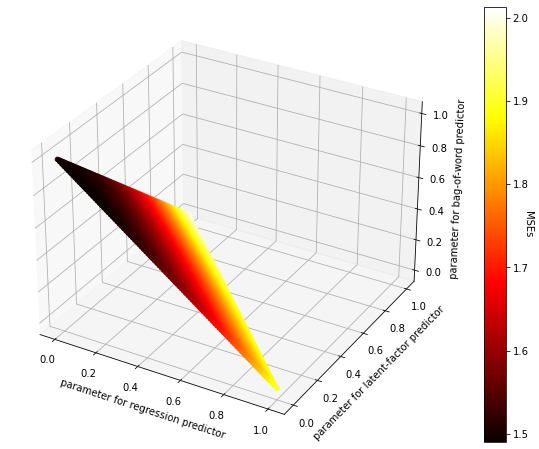

In [463]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')

a1 = [a[0] for a in para_lst]
a2 = [a[1] for a in para_lst]
a3 = [a[2] for a in para_lst]

ax.set_xlabel("parameter for regression predictor")
ax.set_ylabel("parameter for latent-factor predictor")
ax.set_zlabel("parameter for bag-of-word predictor")
img = ax.scatter(a1, a2, a3, c=final_MSEs, cmap=plt.hot())
cbar = fig.colorbar(img)
cbar.set_label('MSEs', rotation=270)
plt.show()